In [1]:
import urllib
import sys
import os
from os.path import expanduser
from datetime import datetime, timedelta

import json
import geopy
from geopy import *

import numpy as np
import seaborn as sns

import matplotlib
from matplotlib import *
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [2]:
#keyfile = sys.argv[1]
keyfile = 'keys'
airnow_key = open(keyfile).readlines()[0]

In [3]:
#Turn a place name (ex. "Seattle, Washington") into longitude and latitude 
def LongLatFromText(location):
    geolocator = Nominatim()
    coded_location = geolocator.geocode(location)
    return (coded_location.longitude, coded_location.latitude)

#Calculate a bounding box around location with a default of 10 miles
def BoundingBox(lng,lat,dist=10.0) :
    #1 deg = 69 mi (or 111 km)
    delta = dist / 69.0  
    return (lng-delta, lat-delta, lng+delta, lat+delta)

In [4]:
def AirNowAPI(llng,llat,ulng,ulat,sdate,stime,edate,etime,file=None):
    # API parameters
    options = {}
    options["url"] = "https://airnowapi.org/aq/data/"
    options["parameters"] = "o3,pm25,pm10,co,no2,so2"
    options["data_type"] = "b"
    options["api_key"] = airnow_key
    options["ext"] = "json"
    options["format"] = "application/json"

    options["start_date"] = sdate
    options["start_hour_utc"] = stime
    options["end_date"] = edate
    options["end_hour_utc"] = etime
    options["bbox"] = ('%f,%f,%f,%f') % (llng, llat, ulng, ulat)
    
    # API request URL
    REQUEST_URL = options["url"] \
                    + "?startdate=" + options["start_date"] \
                    + "t" + options["start_hour_utc"] \
                    + "&enddate=" + options["end_date"] \
                    + "t" + options["end_hour_utc"] \
                    + "&parameters=" + options["parameters"] \
                    + "&bbox=" + options["bbox"] \
                    + "&datatype=" + options["data_type"] \
                    + "&format=" + options["format"] \
                    + "&api_key=" + options["api_key"]

    try:
        # Request AirNowAPI data
        print ("Requesting AirNowAPI data...")

        # User's home directory.
        home_dir = expanduser("~")
        if (file==None) :
            download_file_name = "AirNowAPI" + datetime.now().strftime("_%Y%M%d%H%M%S." + options["ext"])
        else :
            download_file_name = file
        download_file = os.path.join(home_dir, download_file_name)

        # Perform the AirNow API data request
        api_data = urllib.request.urlretrieve(REQUEST_URL,download_file)
        
        # Download complete
        print ("Download URL: %s" % REQUEST_URL)
        print ("Download File: %s" % download_file)
    
    except Exception as e:
        print ("Unable perform AirNowAPI request. %s" % e)
        sys.exit(1)
        
    return download_file

def AirNowAPI2(lng,lat,sdate,stime,edate,etime,dist=10.0,file=None):
    llng, llat, ulng, ulat = BoundingBox(lng,lat,dist)
    return AirNowAPI( llng, llat, ulng, ulat, sdate, stime, edate, etime, file ) 

In [5]:
#set today (the past hour)
nowdate  = datetime.now()
nowday   = str(nowdate.date())
nowtime  = str(nowdate.hour)

prevdate = nowdate - timedelta(hours=0)
prevday  = str(prevdate.date())
prevtime = str(prevdate.hour)

In [6]:
#the USA
jsonfilename = AirNowAPI(-124.98,24.93,-66.62,49.55, prevday, prevtime, nowday, nowtime)

file = open(jsonfilename)
json_data3 = json.loads(file.read())

Requesting AirNowAPI data...
Download URL: https://airnowapi.org/aq/data/?startdate=2017-04-25t12&enddate=2017-04-25t12&parameters=o3,pm25,pm10,co,no2,so2&bbox=-124.980000,24.930000,-66.620000,49.550000&datatype=b&format=application/json&api_key=C5E9988D-0A07-4EAD-B3B5-C9E4DCB207C7

Download File: /Users/yamaoka/AirNowAPI_20173825123859.json


In [7]:
pm25data3 = list(filter(lambda x: x['Parameter']=='PM2.5',json_data3))

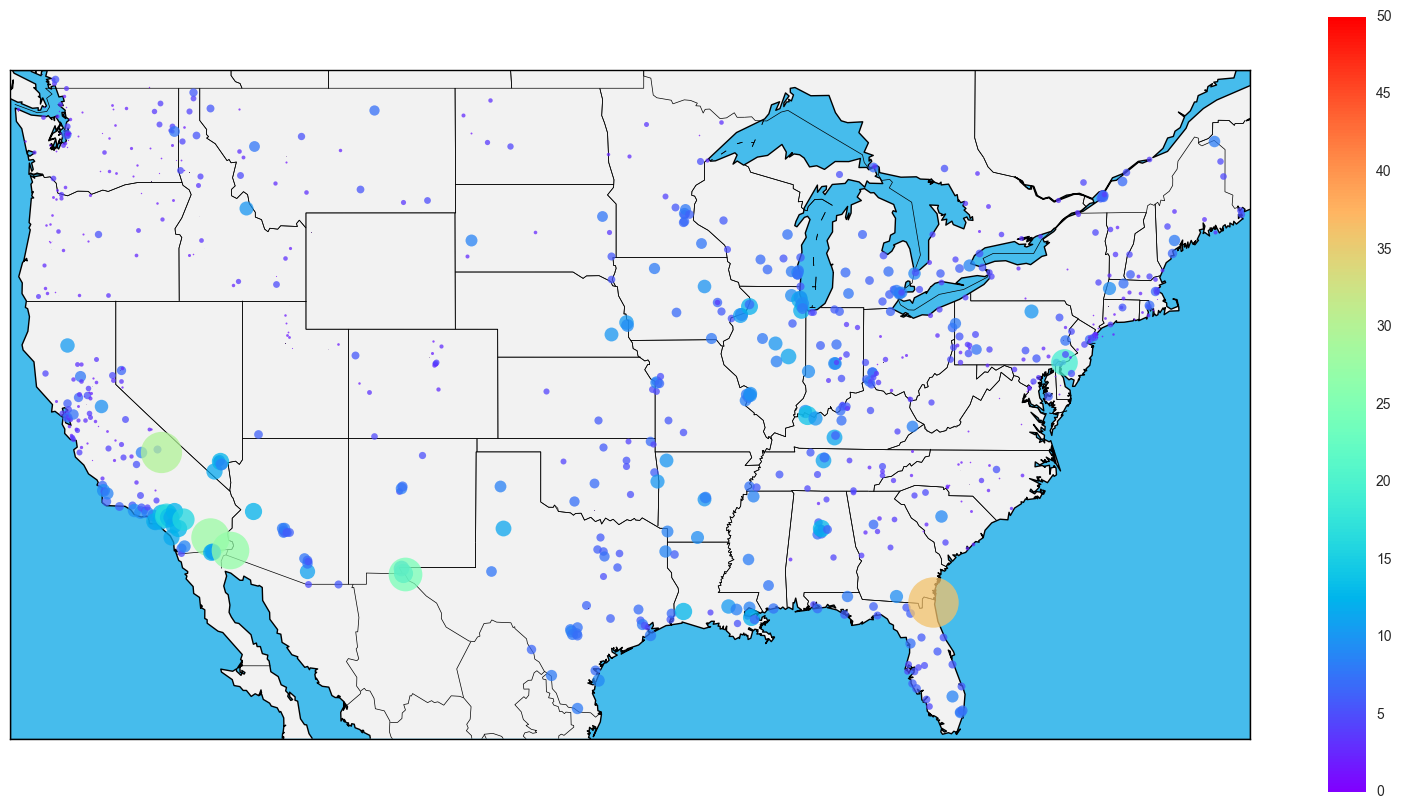

In [8]:
import matplotlib.cm
 
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

fig, ax = plt.subplots(figsize=(20,10))
llng, llat, ulng, ulat = -124.98,24.93,-66.62,49.55

m = Basemap(resolution='l', # c, l, i, h, f or None
            projection='merc',
            llcrnrlon=llng, llcrnrlat=llat, urcrnrlon=ulng, urcrnrlat=ulat,area_thresh=10000)

m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.drawstates()
m.drawcountries()

norm = matplotlib.colors.Normalize(vmin=0, vmax=50, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='rainbow')

def plot_point(loc):
    x,y = m(loc['Longitude'], loc['Latitude'])
    size = loc['Value']
    m.plot(x,y, 'o', markersize=size, color=mapper.to_rgba(size), alpha=0.75)
  
dummy = list( map(plot_point, pm25data3) )

mapper.set_array(pm25data3)
plt.colorbar(mapper)
plt.show()

In [16]:
import folium

fancy_map = folium.Map(location=[38.0000, -97.0000], zoom_start=4)
fancy_map.fit_bounds([[24.93,-124.98], [49.55,-66.62]]) #-124.98,24.93,-66.62,49.55,

for row in pm25data3 :
    folium.RegularPolygonMarker([row['Latitude'], row["Longitude"]], popup=( str(row['Value']) + ' UG/M**3'),
                                color='#21c9ef', number_of_sides=5,
                                radius=6, opacity=0.5).add_to(fancy_map)
fancy_map.save('fancy_map.html')
fancy_map

In [10]:
#set past 3 days
nowdate  = datetime.now()
nowday   = str(nowdate.date())
nowtime  = str(nowdate.hour)

prevdate = nowdate - timedelta(days=3)
prevday  = str(prevdate.date())
prevtime = str(prevdate.hour)

In [11]:
commonradius = 20.0 # radius around location

place1 = 'seattle,wa'
lng , lat = LongLatFromText(place1)
jsonfilename = AirNowAPI2(lng, lat, prevday, prevtime, nowday, nowtime, commonradius)
#jsonfilename = AirNowAPI2(lng, lat,'2016-09-01','12','2016-09-03','23',commonradius)
file = open(jsonfilename)
json_data1 = json.loads(file.read())

place2 = 'new york,ny'
lng , lat = LongLatFromText(place2)
jsonfilename = AirNowAPI2(lng, lat, prevday, prevtime, nowday, nowtime, commonradius)
#jsonfilename = AirNowAPI2(lng, lat,'2016-09-01','12','2016-09-03','23',commonradius)
file = open(jsonfilename)
json_data2 = json.loads(file.read())

Requesting AirNowAPI data...
Download URL: https://airnowapi.org/aq/data/?startdate=2017-04-22t12&enddate=2017-04-25t12&parameters=o3,pm25,pm10,co,no2,so2&bbox=-122.619917,47.313977,-122.040207,47.893687&datatype=b&format=application/json&api_key=C5E9988D-0A07-4EAD-B3B5-C9E4DCB207C7

Download File: /Users/yamaoka/AirNowAPI_20174025124023.json
Requesting AirNowAPI data...
Download URL: https://airnowapi.org/aq/data/?startdate=2017-04-22t12&enddate=2017-04-25t12&parameters=o3,pm25,pm10,co,no2,so2&bbox=-74.276436,40.440744,-73.696726,41.020454&datatype=b&format=application/json&api_key=C5E9988D-0A07-4EAD-B3B5-C9E4DCB207C7

Download File: /Users/yamaoka/AirNowAPI_20174025124051.json


In [12]:
pm25data1 = list(filter(lambda x: x['Parameter']=='PM2.5',json_data1))
pm251 = list(map(lambda x: x['Value'], pm25data1))
date1 = list(map(lambda x: x['UTC'], pm25data1))
datesimp1 = list(set(date1))
pm25avg1 = []
for c in datesimp1 :
    onedaylist = list(filter(lambda x: x['UTC']==c,pm25data1))
    oneday = list(map(lambda x: x['Value'], onedaylist))
    pm25avg1.append(np.mean(oneday))

pm25data2 = list(filter(lambda x: x['Parameter']=='PM2.5',json_data2))
pm252 = list(map(lambda x: x['Value'], pm25data2))
date2 = list(map(lambda x: x['UTC'], pm25data2))
datesimp2 = list(set(date1))
pm25avg2 = []
for c in datesimp2 :
    onedaylist = list(filter(lambda x: x['UTC']==c,pm25data2))
    oneday = list(map(lambda x: x['Value'], onedaylist))
    pm25avg2.append(np.mean(oneday))

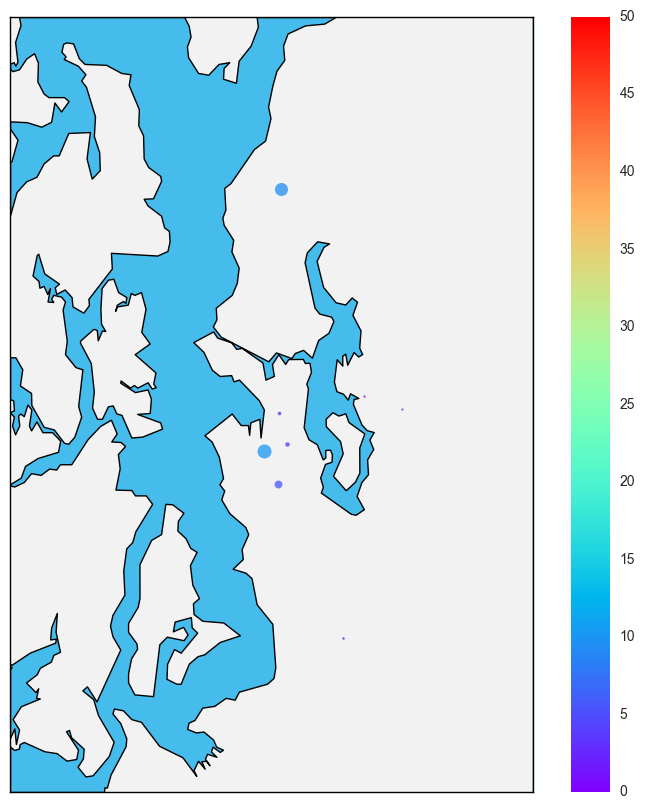

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
lng , lat = LongLatFromText(place1)
llng, llat, ulng, ulat = BoundingBox(lng,lat,25.0)
m = Basemap(resolution='h', # c, l, i, h, f or None
            projection='merc',
            lat_0=lat, lon_0=lng,
            llcrnrlon=llng, llcrnrlat=llat, urcrnrlon=ulng, urcrnrlat=ulat)

m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.drawstates()
m.drawcountries()

plot_time = pm25data1[0]['UTC'] #get most resent time
map_pm25data1 = list(filter(lambda x: x['UTC']==plot_time,pm25data1))

dummy = list( map(plot_point, map_pm25data1) )

mapper.set_array(map_pm25data1)
plt.colorbar(mapper)
plt.show()

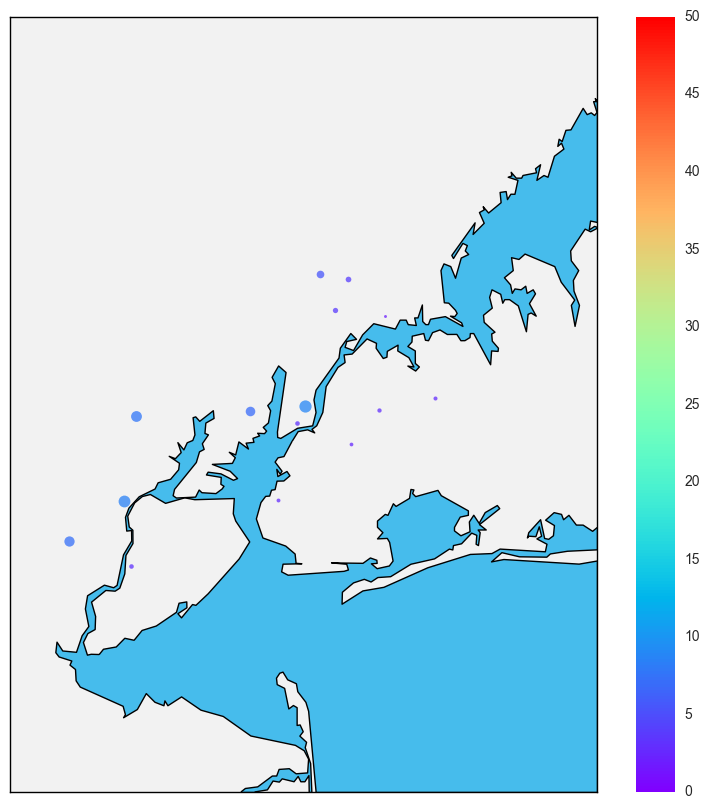

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
lng , lat = LongLatFromText(place2)
llng, llat, ulng, ulat = BoundingBox(lng,lat,25.0)
m = Basemap(resolution='h', # c, l, i, h, f or None
            projection='merc',
            lat_0=lat, lon_0=lng,
            llcrnrlon=llng, llcrnrlat=llat, urcrnrlon=ulng, urcrnrlat=ulat)

m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
#m.drawstates()
m.drawcountries()
 
plot_time = pm25data2[0]['UTC'] #get most resent time
map_pm25data2 = list(filter(lambda x: x['UTC']==plot_time, pm25data2))

dummy = list( map(plot_point, map_pm25data2) )

mapper.set_array(map_pm25data2)
plt.colorbar(mapper)
plt.show()

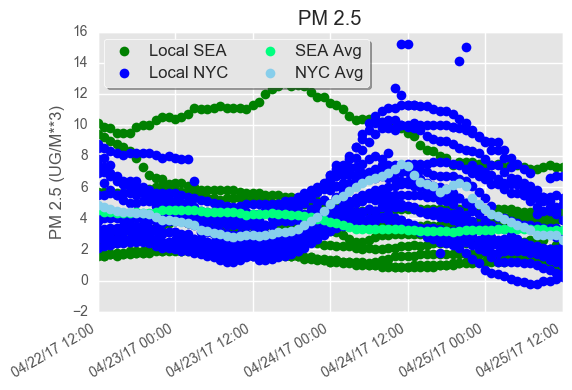

In [15]:
matplotlib.style.use('ggplot')

fig = plt.figure()
ax = fig.add_subplot(1,1,1)  

plt.plot_date(x=date1, y=pm251, color='g', label='Local SEA')
plt.plot_date(x=date2, y=pm252, color='b', label='Local NYC')
plt.plot_date(x=datesimp1, y=pm25avg1, color='springgreen', label='SEA Avg')
plt.plot_date(x=datesimp2, y=pm25avg2, color='skyblue', label='NYC Avg')
plt.title("PM 2.5")
plt.ylabel("PM 2.5 (UG/M**3)")
plt.grid(True)

ax.xaxis.set_major_locator(mdates.HourLocator(interval=12))   #to get a tick every 15 minutes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%D %H:%M'))     #optional formatting 
fig.autofmt_xdate()

# Now add the legend with some customizations.
legend = ax.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, shadow=True, fancybox=True, frameon=True)

# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

plt.show()